In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)
df_att = pd.read_csv('attributes.csv', header=0)
df_des = pd.read_csv('product_descriptions.csv', header=0)

#### Num of search term distribution

In [3]:
def search_term_analysis(df, comment):
    search_terms = [search_term.split() for search_term in df.search_term]
    num_words_used = [len(search_term) for search_term in search_terms]
    avg_terms_used = sum(num_words_used) / float(len(search_terms))
    print 'num_words_used: {}'.format(Counter(num_words_used))
    print 'avg_terms_used: {}'.format(avg_terms_used)
    
    return search_terms

In [4]:
df_train.head()
df_train.describe()
search_terms_train = search_term_analysis(df_train, 'Training Data...')

num_words_used: Counter({3: 26575, 2: 18386, 4: 14847, 5: 6601, 1: 4503, 6: 2076, 7: 741, 8: 204, 9: 80, 11: 31, 10: 10, 12: 9, 14: 4})
avg_terms_used: 3.15920720429


In [5]:
df_test.head()
search_terms_test = search_term_analysis(df_test, 'Training Data...')

num_words_used: Counter({3: 56420, 2: 51329, 4: 28100, 1: 12772, 5: 12004, 6: 4004, 7: 1241, 8: 469, 9: 145, 10: 104, 12: 54, 11: 46, 14: 4, 13: 1})
avg_terms_used: 2.98237478478


#### Num of unique products

In [6]:
print 'training data - num of records: {0}, num unique products: {1}'.format(len(df_train), len(set(df_train.product_uid)))
print 'testing data - num of records: {0}, num unique products: {1}'.format(len(df_test), len(set(df_test.product_uid)))

training data - num of records: 74067, num unique products: 54667
testing data - num of records: 166693, num unique products: 97460


#### Group by num of search terms

In [7]:
search_by_num_words = defaultdict(list)
for search_term in search_terms_train + search_terms_test:
    search_by_num_words[len(search_term)].append(search_term)

In [8]:
search_by_num_words[1]

[['microwaves'],
 ['disposer'],
 ['bamboo'],
 ['grayson'],
 ['post'],
 ['outdoorfurniture'],
 ['wiremesh'],
 ['post'],
 ['4x6'],
 ['melnor'],
 ['deckpaint'],
 ['silicone'],
 ['chipper'],
 ['bidet'],
 ['slatwall'],
 ['respirator'],
 ['lamp'],
 ['Lawnmowers'],
 ['closetmade'],
 ['closetmaid'],
 ['post'],
 ['omnifilter'],
 ['colosso'],
 ['respirator'],
 ['miricale'],
 ['sheetrock'],
 ['bathrooms'],
 ['bootz'],
 ['porcelain'],
 ['aspiradora'],
 ['shredder'],
 ['chipper'],
 ['Fuses'],
 ['home-flex'],
 ['knob'],
 ['Lawnmowers'],
 ['hindges'],
 ['lathe'],
 ['roller'],
 ['clab'],
 ['chaise'],
 ['tent'],
 ['cieling'],
 ['gates'],
 ['ceadar'],
 ['pruners'],
 ['barreir'],
 ['water'],
 ['azek'],
 ['azek'],
 ['closetmaid'],
 ['stringer'],
 ['thermoclear'],
 ['stakes'],
 ['slatwall'],
 ['roller'],
 ['slatwall'],
 ['roller'],
 ['huskvarna'],
 ['post'],
 ['plywoods'],
 ['artificial'],
 ['canopy'],
 ['awnings'],
 ['frp'],
 ['rounds'],
 ['round'],
 ['rounds'],
 ['closetmaid'],
 ['sinks'],
 ['roundup'],


In [9]:
y_train = df_train.relevance

In [10]:
# merge training and testing data sets to single dataframe

df_train_copy = df_train.drop('relevance', axis=1)
df_train_copy['dataset'] = 'train'

df_test_copy = df_test.copy()
df_test_copy['dataset'] = 'test'

df = pd.concat([df_train_copy, df_test_copy], ignore_index=True)

In [11]:
# engineer features

# number of words match in title (search term and product title)
# number of words in search term
    # find root of word
# importance measure of matched words (log-based)
# importance measure of unmatched words (log-based)

# remove measurement words and numbers - keyword filter

In [12]:
def get_num_words_in_search(search_terms):
    num_words_in_search = []
    for terms in search_terms:
        num_words_in_search.append(len([word for word in terms.split(' ') if word.strip() != '']))
    return num_words_in_search   

In [13]:
df['num_words_in_search'] = get_num_words_in_search(df['search_term'].values)

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

def get_num_words_matched_array(search_terms, product_titles, num_words_in_search, 
                                use_stemmer=True):
    num_words_matched = []
    terms_list = []
    for terms, title, num_words in zip(search_terms, product_titles, num_words_in_search):
        words_in_terms = []
        words_in_title = []
        if use_stemmer:
            for word in terms.split(' '):
                if word.strip() != '':
                    try:
                        words_in_terms.append(stemmer.stem(word.strip().lower()))
                    except:
                        words_in_terms.append(word.strip().lower())

            for word in title.split(' '):
                if word.strip() != '':
                    try:
                        words_in_title.append(stemmer.stem(word.strip().lower()))
                    except:
                        words_in_title.append(word.strip().lower())
        else:
            words_in_terms = set([word.strip().lower() for word in terms.split(' ')])
            words_in_title = set([word.strip().lower() for word in title.split(' ')])

        num_words_matched.append(len(set(words_in_terms) & set(words_in_title)) / float(num_words))
    return num_words_matched

In [15]:
df['num_words_matched'] = get_num_words_matched_array(df['search_term'].values, 
                                                      df['product_title'].values, 
                                                      df['num_words_in_search'].values)

/mnt/home/anselm/py27/local/lib/python2.7/site-packages/nltk/stem/porter.py:274: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if word[-1] == 's':


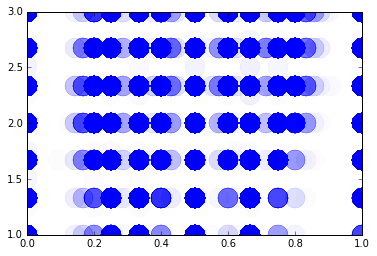

In [16]:
plt.plot(df['num_words_matched'][df.dataset == 'train'].values[:], y_train[:], '.', alpha=0.01, markersize=40)

In [17]:
np.corrcoef(df['num_words_matched'][df.dataset == 'train'].values[:], y_train[:])

array([[ 1.        ,  0.33958141],
       [ 0.33958141,  1.        ]])

#### Are all products in product description?

In [18]:
unique_uids = set(df_des.product_uid.values)
len(filter(lambda uid: uid in unique_uids, df.product_uid.values)) / float(len(df.product_uid.values))

1.0

#### Yes

In [19]:
df = pd.merge(df, df_des, how='left', on='product_uid')
df.head()

,id,product_uid,product_title,search_term,dataset,num_words_in_search,num_words_matched,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,train,2,0.500000,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,train,2,0.000000,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,train,2,0.000000,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,train,3,0.333333,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,train,3,1.000000,Update your bathroom with the Delta Vero Singl...


In [20]:
df['num_words_matched_desc'] = get_num_words_matched_array(df['search_term'].values, 
                                                      df['product_description'].values, 
                                                      df['num_words_in_search'].values, use_stemmer=False)

In [21]:
np.corrcoef(df['num_words_matched_desc'][df.dataset == 'train'].values[:], y_train[:])

array([[ 1.        ,  0.24603597],
       [ 0.24603597,  1.        ]])

#### Common words

In [22]:
def map_words_to_stems(searches):
    _terms = []
    for term in set([s.strip().lower() for s in searches.split(' ')]):
        try:
            _terms.append(stemmer.stem(term.strip().lower()))
        except:
            _terms.append(term.strip().lower())
    return _terms

In [23]:
words = []
for terms in df['search_term']:   
    words += map_words_to_stems(terms)

In [24]:
word_counts = Counter(words)

#### Keyword filter

In [25]:
terms = word_counts.keys()
counts = word_counts.values()
x = [[count] for count in counts]

In [26]:
from sklearn.cluster import KMeans
for k in xrange(2, 10):
    estimator = KMeans(n_clusters=k)
    estimator.fit(x)
    print 'k: {0}, score: {1}'.format(k, estimator.score(x))

k: 2, score: -419120746.14
k: 3, score: -238477347.14
k: 4, score: -120215905.168
k: 5, score: -73814375.4284
k: 6, score: -45008440.4222
k: 7, score: -31487418.2952
k: 8, score: -23554900.9151
k: 9, score: -18813809.5645


In [27]:
estimator = KMeans(n_clusters=7)
estimator.fit(x)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [28]:
term_by_cluster = defaultdict(list)
for term, count, cluster in zip(terms, counts, estimator.labels_):
    term_by_cluster[cluster].append(term)

In [29]:
for n, cluster_center in enumerate(estimator.cluster_centers_):
    print 'cluster #: {}, center: {}, size: {}'.format(n, cluster_center, len(term_by_cluster[n]))

cluster #: 0, center: [ 208.18769231], size: 647
cluster #: 1, center: [ 2561.44736842], size: 38
cluster #: 2, center: [ 11286.], size: 2
cluster #: 3, center: [ 1289.73255814], size: 86
cluster #: 4, center: [ 15.92595697], size: 10740
cluster #: 5, center: [ 616.73333333], size: 210
cluster #: 6, center: [ 4452.46666667], size: 15


cluster0 appears to be an appropriate proxy of keywords - low frequency, large size

In [30]:
keyword_set = set(term_by_cluster[0])

In [31]:
def get_num_keywords(x):
    return len(set(map_words_to_stems(x)) & keyword_set)
    
df['num_keywords_in_search'] = df.search_term.map(get_num_keywords)

In [32]:
np.corrcoef(df['num_keywords_in_search'][df.dataset == 'train'].values[:], y_train[:])

array([[ 1.        , -0.01745713],
       [-0.01745713,  1.        ]])

#### XGBoost Classifier

In [33]:
u = np.mean(y_train)

In [34]:
df['mean_relevance'] = np.mean(y_train)

In [35]:
def get_train_test_x(_df, features=None):
    if features:
        _df_train = _df[features][_df.dataset == 'train']
        _df_test = _df[features][_df.dataset == 'test']
    else:
        _df_train = _df[_df.dataset == 'train']
        _df_test = _df[_df.dataset == 'test']
        
        _df_train.drop(['dataset'], axis=1, inplace=True)
        _df_test.drop(['dataset'], axis=1, inplace=True)
        
    return _df_train.values, _df_test.values

In [36]:
from sklearn.metrics import mean_squared_error

def RMSE(y, y_pred):
    return round(mean_squared_error(y, y_pred)**0.5, 3)

In [37]:
import sklearn.preprocessing as pp
le = pp.LabelEncoder()

In [38]:
from sklearn.cross_validation import StratifiedKFold
from itertools import product
from xgboost.sklearn import XGBClassifier

def run_kfold_process(clf, labels, predict_method, classification):
    
    folds = 3
    kfold = StratifiedKFold(y=y_train, n_folds=folds, shuffle=True, random_state=0)
    param_alpha = [0.1, 1, 10]
    history_rmse = [100]
        
    predictions_all = []
    
    if predict_method == 'clf':
        cum_score = 0
        for k, (train, test) in enumerate(kfold):
            clf.fit(x_train[train], labels[train])
            
            if classification:
                output = []
                predicted_probs = clf.predict_proba(x_test[test])
                
                for predicted_prob in predicted_probs:
                    output.append(le.inverse_transform(np.argsort(predicted_prob))[::-1][0])
            else:
                output = clf.predict(x_test[test])
                
            predictions = output
        
            # rescale
#             predictions = (predictions - min(predictions)) / float(max(predictions) - min(predictions)) * 2 + 1
            print 'k: {} ...'.format(k)
            print 'pre-shift u: {}'.format(np.mean(predictions))
            
            # mean shift
#             predictions = predictions + u - np.mean(predictions)
            
            print 'min: {}'.format(min(predictions))
            print 'max: {}'.format(max(predictions))
            print 'post-shift u: {}'.format(np.mean(predictions))
            
            cum_score += RMSE(y_train[test], predictions)
            predictions_all.append(predictions)
            
        rmse = cum_score / float(folds)
        print 'k: {}, RMSE: {}, best: {}'.format(k, rmse, rmse <= min(history_rmse))
        history_rmse.append(rmse)
    
    elif predict_method == 'mean_clf':
        param_weights = [0, 0.1, 0.2, 0.3]
        for weight in param_weights:
            cum_score = 0
            for k, (train, test) in enumerate(kfold):
                
                clf.fit(x_train[train], labels[train])
                output = clf.predict(x_test[test])
                
#                 print df[['product_uid', 'num_words_matched', 'num_words_matched_desc', 'num_keywords_in_search']][df.dataset == 'test'].values[:10]
#                 print x_test[test[:10]]
#                 print output[:10]
                
                pdb.set_trace()
                predictions = weight * output + u
                cum_score += RMSE(y_train[test], predictions)
                predictions_all.append(predictions)
            
            rmse = cum_score / float(folds)
            print 'k: {}, weight: {}, RMSE: {}, best: {}'.format(k, weight, rmse, rmse <= min(history_rmse))
            history_rmse.append(rmse)
    
    return predictions_all

# predict_method: 'mean', 'clf', 'mean_clf' 
# label_method: 'absolute', 'relative'
def train_clf(clf, features=None, predict_method = 'mean_clf', training_label_method = 'absolute', classification=False):    
    
    if predict_method == 'mean':
        
        # no training required
        predictions = 0 * y_train + u
        print RMSE(y_train, predictions)
    
    else:
        if classification:
            labels = le.fit_transform(y_train)
        else:
            if training_label_method == 'absolute':
                labels = y_train
            elif training_label_method == 'relative':
                labels = y_train - u
        
        predictions_all = run_kfold_process(clf, labels, predict_method, classification)
        
        return predictions_all

In [39]:
features = ['num_words_matched', 'num_words_matched_desc', 'num_keywords_in_search']
x_train, x_test = get_train_test_x(df, features)

In [43]:
# xgb = XGBClassifier(max_depth=3, learning_rate=1, n_estimators=50, seed=0, reg_alpha=1, reg_lambda=1) 
# train_clf(xgb, predict_method='mean')

In [44]:
# xgb = XGBClassifier(max_depth=5, learning_rate=0.5, n_estimators=10, seed=0, reg_alpha=1, reg_lambda=1)
# train_clf(xgb, predict_method='clf', training_label_method='absolute')

In [45]:
# xgb = XGBClassifier(max_depth=3, learning_rate=1, n_estimators=50, seed=0, reg_alpha=1, reg_lambda=1) 
# train_clf(xgb, predict_method='mean_clf', training_label_method='relative')

In [46]:
# xgb = XGBClassifier(max_depth=1, learning_rate=0.2, n_estimators=5, 
#                     subsample=0.5, colsample_bytree=1, seed=0)
# train_clf(xgb, predict_method='mean_clf', training_label_method='relative')

In [47]:
# features = ['product_uid', 'num_words_matched', 'num_words_matched_desc', 'num_keywords_in_search']
# x_train, x_test = get_train_test_x(features)

In [48]:
# xgb = XGBClassifier(max_depth=1, learning_rate=0.2, n_estimators=5, 
#                     subsample=0.5, colsample_bytree=1, seed=0)
# train_clf(xgb, predict_method='mean_clf', training_label_method='relative')

#### Logistic Regression

In [49]:
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression()
# train_clf(lr, predict_method='mean_clf', training_label_method='relative')

#### Current Best: 0.533980338695

#### Attributes

In [50]:
df_att.head()

,product_uid,name,value
0,100001,Bullet01,Versatile connector for various 90° connection...
1,100001,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001,Bullet03,Help ensure joints are consistently straight a...
3,100001,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001,Bullet05,Made from 12-Gauge steel


In [51]:
len(df_att['name'])

2044803

In [52]:
# filter out 'bullet' items
att_filtered = df_att['name'][df_att['name'].apply(lambda x: str(x)[:6].lower()) != 'bullet']
num_unique_attributes = set(att_filtered)

# average products per attribute
len(att_filtered) / float(len(num_unique_attributes))

270.01410541945063

In [53]:
att_counts = Counter(att_filtered)
atts = att_counts.keys()
counts = att_counts.values()

#### KMeans to filter trivial attributes
What is trivial? Not applicable to many records

In [54]:
x = [[count] for count in counts]

In [55]:
from sklearn.cluster import KMeans
for k in xrange(2, 20):
    estimator = KMeans(n_clusters=k)
    estimator.fit(x)
    print 'k: {0}, score: {1}'.format(k, estimator.score(x))

k: 2, score: -5719239606.04
k: 3, score: -2900961867.7
k: 4, score: -1879194987.7
k: 5, score: -1062305607.54
k: 6, score: -759135040.617
k: 7, score: -530079103.815
k: 8, score: -323243207.281
k: 9, score: -235000771.753
k: 10, score: -175394074.628
k: 11, score: -143047151.523
k: 12, score: -117019339.11
k: 13, score: -93954128.8142
k: 14, score: -73430177.2408
k: 15, score: -60472900.5726
k: 16, score: -48854563.6733
k: 17, score: -42122142.8899
k: 18, score: -36540976.7632
k: 19, score: -30805081.6776


In [56]:
estimator = KMeans(n_clusters=10)
estimator.fit(x)
att_by_cluster = defaultdict(list)

for att, count, cluster in zip(atts, counts, estimator.labels_):
    att_by_cluster[cluster].append(att)

for n, cluster_center in enumerate(estimator.cluster_centers_):
    print 'cluster #: {}, center: {}, size: {}'.format(n, cluster_center, len(att_by_cluster[n]))

cluster #: 0, center: [ 3223.78947368], size: 38
cluster #: 1, center: [ 48.57547587], size: 4519
cluster #: 2, center: [ 43341.5], size: 2
cluster #: 3, center: [ 86250.], size: 1
cluster #: 4, center: [ 16880.8], size: 5
cluster #: 5, center: [ 56495.66666667], size: 3
cluster #: 6, center: [ 6384.71428571], size: 14
cluster #: 7, center: [ 28215.66666667], size: 3
cluster #: 8, center: [ 1327.09473684], size: 190
cluster #: 9, center: [ 423.22964169], size: 613


Choose clusters 1, 2, 3, 4, 7, 8

Then maybe clusters 5, 6

Not using attributes from cluster 0, 9

#### Merge main df with dt_att

In [57]:
selected_clusters = [1, 2, 3, 4, 7, 8]
selected_attributes = []

for x in att_by_cluster.keys():
    if x in selected_clusters:
        selected_attributes += att_by_cluster[x]

In [179]:
def filter_attributes(row):
    if (row[0], row[1]) in filter_set:
        return 0
    return 1

def get_attributes_pivoted_df():
    by_attribute = df_att.groupby(['product_uid', 'name']).count()
    filter_set = by_attribute[by_attribute.value > 1].reset_index()[['product_uid', 'name']].values
    filter_set = set([(uid, name) for uid, name in filter_set.tolist()])
    
    _df = df_att.copy()
    _df['keep'] = df_att.apply(filter_attributes, axis=1)
    _df = _df[_df['keep'] == 1]
    _df = _df.dropna(how='any')
    _df = _df.pivot(index='product_uid', columns='name', values='value')
    _df.reset_index(inplace=True)
    
    return _df

In [180]:
_df = get_attributes_pivoted_df()

In [181]:
# _df = _df[['product_uid'] + selected_attributes]
# _df = _df.fillna(-1)

### Merge

In [ ]:
df_merged = pd.merge(df, _df, how='left', on='product_uid')

In [ ]:
# searches = df_merged['search_term']
columns_to_remove = ['id', 'product_uid', 'product_title', 'product_description', 'mean_relevance']
for column in columns_to_remove:
    del df_merged[column]

In [ ]:
def is_number(x):
    
    try:
        float(x)
        return True
    except ValueError:
        return False
        
def get_num_words_matched_array(attribute_values, searches): 
    
    num_terms_matched = []
    for attribute_value, search in zip(attribute_values, searches):
        words_att = []
        words_search = []
        
        try:
            if is_number(attribute_value):
                attribute_value = [str(attribute_value)]
            
            if not isinstance(attribute_value, list):
                attribute_value = [attribute_value]
                
            for word_att in attribute_value:
                try:
                    words_att.append(stemmer.stem(word_att.strip().lower()))
                except:
                    words_att.append(word_att.strip().lower())
            
            if not isinstance(search, list):
                search = [search]
                
            for word_search in search:
                try:
                    words_search.append(stemmer.stem(word_search.strip().lower()))
                except:
                    words_search.append(word_search.strip().lower())
                    
        except:
            pdb.set_trace()
        
        num_terms_matched.append(len(set(words_att) & set(words_search)))
                                 
    return num_terms_matched
                                 
for _feature in df_merged.columns:
    if _feature not in ['dataset', 'num_words_in_search', 'search_term', 'num_words_matched', 
                        'num_words_matched_desc', 'num_words_matched_desc']:
        
        new_feature_name = _feature + '_search_matched'    
        df_merged[new_feature_name] = get_num_words_matched_array(df_merged[_feature], searches)
#         del df_merged[_feature]
        print 'feature: {}, # of matches: {}'.format(_feature, sum(df_merged[new_feature_name].values))
    

In [ ]:
for _feature in df_merged.columns:
    if _feature not in ['dataset', 'num_words_in_search', 'num_words_matched', 
                        'num_words_matched_desc', 'num_words_matched_desc']:
        try:
            print df_merged[['search_term', _feature, _feature + '_search_matched' ]].iloc[:10]
        except:
            pass

#### Part-of-Speech Tagger

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
from nltk.tag.perceptron import PerceptronTagger
tagger = PerceptronTagger()

pos_list = []
count = 0
for search in df.search_term:
    if count % 50000 == 0:
        print str(count) + '...'
    count += 1
    
    _, pos = zip(*nltk.tag._pos_tag(word_tokenize(search), None, tagger))
    pos_list.append(pos)
    

In [ ]:
elements = [e for x in pos_list for e in x]
unique_pos = set(elements)

In [ ]:
df_bak = df.copy()

In [ ]:
pos_counts = [Counter(x) for x in pos_list]
for pos in unique_pos:
    df['num_matched_pos_' + pos] = [x[pos] for x in pos_counts]

In [ ]:
df_new = df.copy()

In [ ]:
df_new = df_new.set_index(['id'])
df_new = df_new.drop(['product_uid', 'product_title', 'search_term', 'product_description', 'mean_relevance'], axis=1)

In [ ]:
x_train, x_test = get_train_test_x(df_new[['dataset','num_words_matched']])
df_new = df_new.drop(['dataset'], axis=1) 

## Feature Engineering

In [150]:
# df1 = df[['dataset','product_title','search_term']].copy()

In [159]:
# import math

# def tf(word, blob):
# #     return blob.words.count(word) / len(blob.words)
#     return sum([1 for _word in blob if word == _word]) / float(len(blob))

# def n_containing(word, bloblist):
#     return sum(1 for blob in bloblist if word in blob)

# def idf(word, bloblist):
#     return math.log(len(bloblist) / float((1 + n_containing(word, bloblist))))

# def tfidf(word, blob, bloblist):
#     return tf(word, blob) * idf(word, bloblist)

In [182]:
df_pivoted_attributes = get_attributes_pivoted_df()

In [195]:
df1 = df[['dataset', 'product_uid', 'product_title', 'search_term']].copy()

from nltk.corpus import stopwords
stopwords_eng = set(stopwords.words("english"))
    
def ratio_words_matched(searches, match_phrases, remove_stopwords=False):
    
    output_array = []
    for search_terms, match_phrase in zip(searches, match_phrases):
        if match_phrase == float('nan'):
            output_array.append(0)
        else:
            search_terms = str(search_terms)
            search_terms = search_terms.lower()
            
            match_phrase = str(match_phrase)
            match_phrase = match_phrase.lower()
                
            if remove_stopwords:
                search_terms = ' '.join([word for word in search_terms.split() if word not in stopwords_eng])

            search_words = search_terms.split(' ')
            match_phrase_words = match_phrase.split(' ')

            num_matches = sum([1 for word in search_words if word in match_phrase_words])
            output_array.append(num_matches / float(len(search_words)))            
    return output_array

def num_chars_in_search(searches, remove_stopwords=False):
    
    output_array = []
    for search_terms in searches:
        if remove_stopwords:
            search_terms = ' '.join([word for word in search_terms.split() if word not in stopwords_eng])
        output_array.append(len(search_terms))
    return output_array      

def num_stopwords_in_search(searches):
    output_array = []
    for search_terms in searches:
        _stopwords = [word for word in search_terms.split() if word in stopwords_eng]
        output_array.append(len(_stopwords))
    return output_array      

def attribute_match(attribute):
    
    _df_merged = pd.merge(df1, df_pivoted_attributes[['product_uid', attribute]], how='left', on='product_uid')
    output_array = ratio_words_matched(_df_merged.search_term, _df_merged[attribute])

    
#         df_att[df_att.product_uid == product_uid & 
#            len(set(search_terms) & set(df_att[column].split(' '))) > 0]

# def num_tdidf_words(searches):
#     output_array = []
#     for search in searches:
#         for word in search.split(' '):
#             # calculate tdidf score
#             tfidf_score = tfidf(word, search, searches)

df1['num_chars_in_search'] = num_chars_in_search(df1.search_term, remove_stopwords=True)    
df1['ratio_words_matched'] = ratio_words_matched(df1.search_term, 
                                                              df1.product_title, 
                                                              remove_stopwords=True)
df1['num_stopwords_in_search'] = num_stopwords_in_search(df1.search_term)

df1['brand_matched'] = attribute_match('MFG Brand Name')

# df1['num_tdidf_words'] = num_tdidf_words(df1.search_term)

# 'MFG Brand Name'
# 'Material'
# 'Bullet01'
# 'Bullet02'
# ...
# 'Bullet04'

In [ ]:
df1.drop(['product_uid', 'product_title', 'search_term'], axis=1, inplace=True)
x_train, x_test = get_train_test_x(df1)

## Classifers

### Regression

In [156]:
# from sklearn.svm import SVR
# clf_svr = SVR(C=1.0, epsilon=0.2)
# predictions_all = train_clf(clf_svr, predict_method='clf', training_label_method='absolute')

In [157]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=20, n_estimators=20, random_state=0)
predictions_all = train_clf(rfr, predict_method='clf', training_label_method='absolute')

k: 0 ...
pre-shift u: 2.38469905486
min: 1.09621071429
max: 3.0
post-shift u: 2.38469905486
k: 1 ...
pre-shift u: 2.39140758567
min: 1.3856284943
max: 3.0
post-shift u: 2.39140758567
k: 2 ...
pre-shift u: 2.38848611122
min: 1.13203928571
max: 3.0
post-shift u: 2.38848611122
k: 2, RMSE: 0.574333333333, best: True


In [158]:
print rfr.feature_importances_
df1.head()

[ 0.29803465  0.63901028  0.06295507]


,dataset,num_chars_in_search,ratio_words_matched_wo_stopwords,num_stopwords_in_search
0,train,13,0.500000,0
1,train,9,0.000000,0
2,train,4,0.000000,1
3,train,16,0.333333,0
4,train,13,1.000000,1


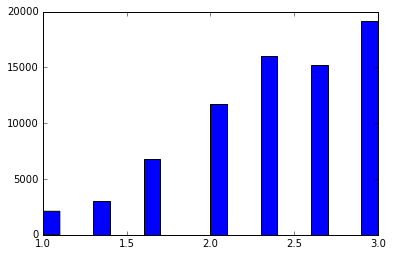

In [140]:
plt.hist(y_train, 20)
plt.show()

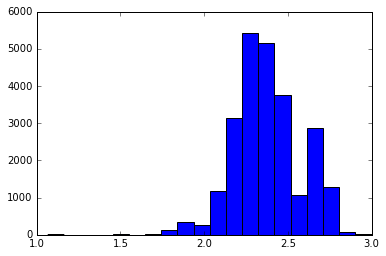

In [131]:
plt.hist(predictions_all[0], 20)
plt.show() # rfr

### Classification

In [87]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=20, seed=0)
predictions_all = train_clf(xgb, predict_method='clf', training_label_method='absolute')

k: 0 ...
pre-shift u: 2.69494674604
min: 1.67
max: 3.0
post-shift u: 2.69494674604
k: 1 ...
pre-shift u: 2.73175422253
min: 1.67
max: 3.0
post-shift u: 2.73175422253
k: 2 ...
pre-shift u: 2.71800850719
min: 1.0
max: 3.0
post-shift u: 2.71800850719
k: 2, RMSE: 0.723333333333, best: True


In [88]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=30, n_estimators=10, random_state=0)
predictions_all = train_clf(rfc, predict_method='clf', training_label_method='absolute', classification=True)

k: 0 ...
pre-shift u: 2.70065686632
min: 1.0
max: 3.0
post-shift u: 2.70065686632
k: 1 ...
pre-shift u: 2.67966543805
min: 1.0
max: 3.0
post-shift u: 2.67966543805
k: 2 ...
pre-shift u: 2.70113712781
min: 1.0
max: 3.0
post-shift u: 2.70113712781
k: 2, RMSE: 0.731333333333, best: True


#### GraphViz

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.externals.six import StringIO  
import pydotplus
dot_data = StringIO() 

import graphviz

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(x_train, y_train)

for i, _tree in enumerate(rfc.estimators_):
    with open('figures/tree_' + str(i) + '.dot', 'w') as dotfile:
        dot_data = StringIO() 
        tree.export_graphviz(_tree, out_file=dot_data)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
        
#         graph = pydotplus.graph_from_dot_file('tree_0.dot') 
#         graph.write_pdf("tree.pdf") 

#### Check if variance of relevance scores is high

In [ ]:
scores_by_num_terms = defaultdict(list)
for num_terms, score in zip(df.num_words_in_search[df.dataset == 'train'], y_train):
    scores_by_num_terms[num_terms].append(score)

In [ ]:
u_scores_by_num_terms = defaultdict(list)
for k, v in scores_by_num_terms.iteritems():
    u_scores_by_num_terms[k] = np.mean(v)
    print 'num_terms: {0}, n_samples: {1}, u_score: {2}'.format(k, len(v), round(np.mean(v),2))

In [ ]:
preds = [] 
for num_terms in df.num_words_in_search[df.dataset == 'test']:
    if u_scores_by_num_terms[num_terms]:
        preds.append(u_scores_by_num_terms[num_terms])
    else:
        preds.append(u)

#### Other

In [ ]:
len(df_des)
df_des.head()

#### out 

In [ ]:
import csv
import os

with open('results/results_base_2.csv', 'wb') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['id', 'relevance'])
    for id, pred in zip(df_test.id.values, preds):
        csv_writer.writerow([id, pred])